In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_c import WurstCore
from train_b import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests
import numpy as np
from tqdm import tqdm
import uuid

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# SETUP WARPCORE
config_file = 'configs/corruption_c_3b.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 1

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

# STAGE B
config_file_b = 'configs/finetune_b_3b.yml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    config_file_b['use_fsdp'] = False
    config_file_b['batch_size'] = 4
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device
)

In [3]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
models = warpcore.setup_models(extras)
data = warpcore.setup_data(extras)
models.generator.bfloat16()
print("CONTROLNET READY")

extras_b = warpcore_b.setup_extras_pre()
models_b = warpcore_b.setup_models(extras_b)
models_b.generator.bfloat16()
print("STAGE B READY")
pass

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.6.mlp.fc1.weight', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.1.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.10.self_attn.k_proj.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.11.mlp.fc1.weight', '

Training with batch size 1 (1/GPU)
CONTROLNET READY


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


/fsx/home-warp/env2/lib/python3.8/site-packages/webdataset/handlers.py:33: UserWarning: ReadError("unexpected end of data @ <Pipe (('aws s3 cp s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_MJ_1M_HOT/00076_1.tar -',), {'shell': True, 'bufsize': 8192})>")
  warnings.warn(repr(exn))
/fsx/home-warp/env2/lib/python3.8/site-packages/webdataset/handlers.py:33: UserWarning: ReadError('unexpected end of data', <webdataset.gopen.Pipe object at 0x7fd4f6b3d070>, 'pipe:aws s3 cp s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_MJ_1M_HOT/00076_1.tar -')
  warnings.warn(repr(exn))
/fsx/home-warp/env2/lib/python3.8/site-packages/webdataset/handlers.py:33: UserWarning: ReadError("unexpected end of data @ <Pipe (('aws s3 cp s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_MJ_500K_RISING/00033_1.tar -',), {'shell': True, 'bufsize': 8192})>")
  warnings.warn(repr(exn))
/fsx/home-warp/env2/lib/python3.8/site-packages/webdataset/handlers.py:33: UserWarning:

ORIG SIZE: torch.Size([4, 3, 1152, 864])
SCALED SIZE: torch.Size([4, 3, 864, 640])


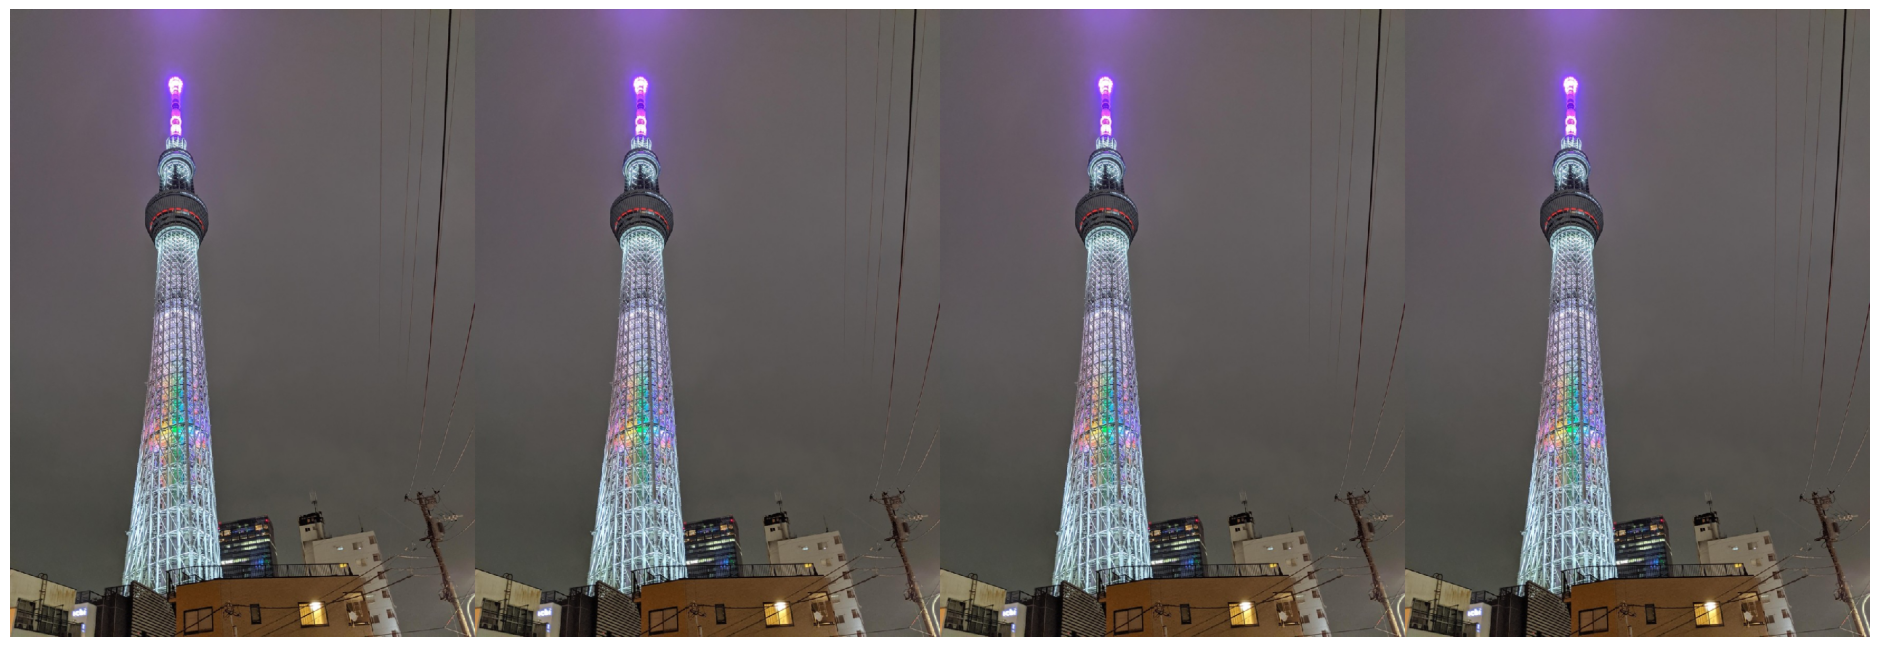

On a foggy night, the image depicts Tokyo Skytree. It is surrounded by white buildings and has a magnificent structure, emitting purple light on top of it. Below are yellow houses and black utility poles with overhead wires.


In [4]:
# PREVIEW BATCH
batch = next(data.iterator)
batch['images'] = batch['images'].expand(4, -1, -1, -1)
batch['captions'] = batch['captions'] * 4
print("ORIG SIZE:", batch['images'].shape)

effnet_factor = 3/4
effnet_height, effnet_width = int(((batch['images'].size(-2)*effnet_factor)//32)*32), int(((batch['images'].size(-1)*effnet_factor)//32)*32)
batch['images'] = torchvision.transforms.functional.resize(batch['images'], (effnet_height, effnet_width), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
print("SCALED SIZE:", batch['images'].shape)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'][0])

/fsx/home-warp/env2/lib/python3.8/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


T: 0.31670216133651696 STEPS: 6


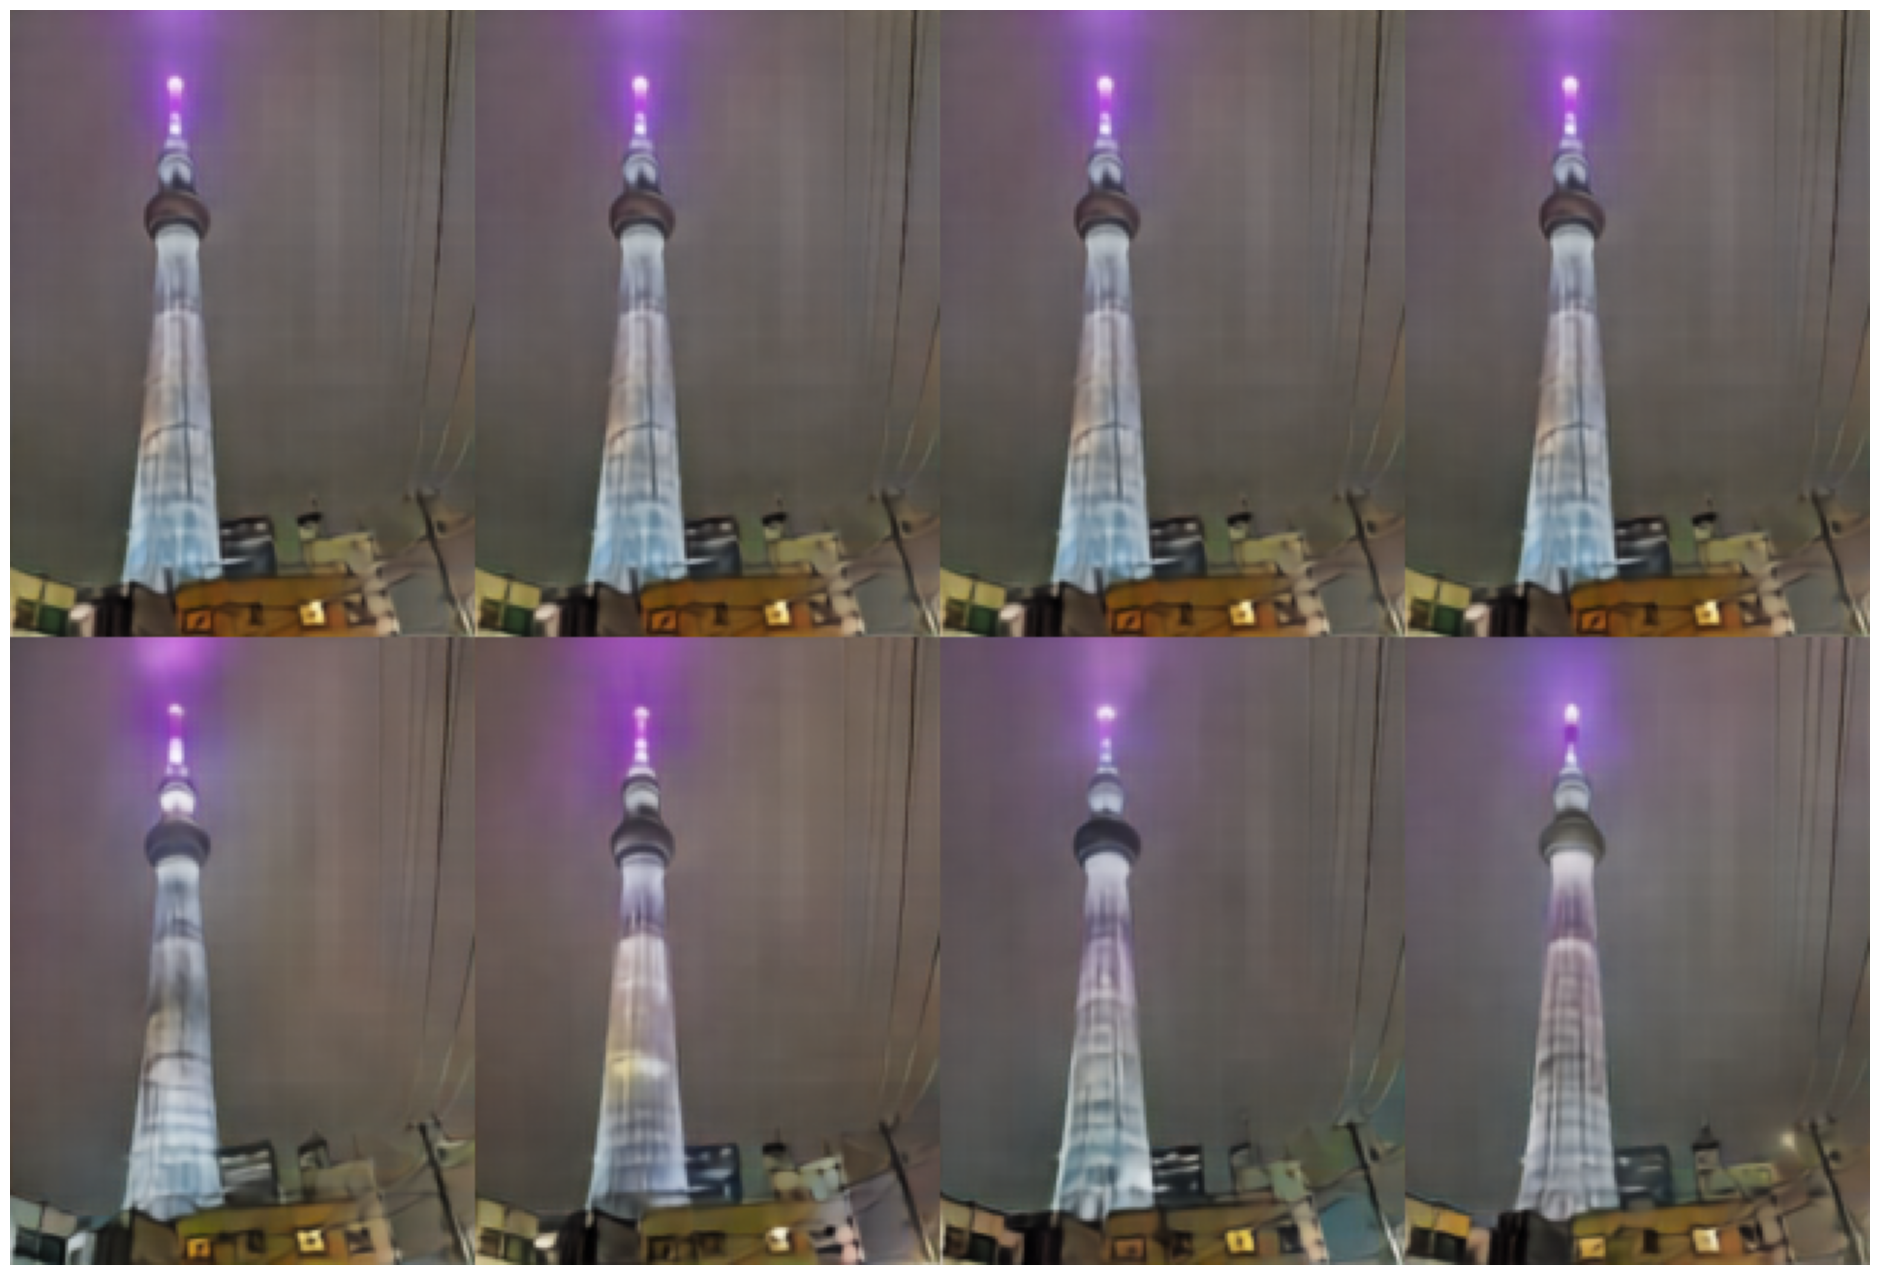

In [5]:
# PREPARE CONDITIONS
conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    effnet_latents = warpcore.encode_latents(batch, models, extras)
    decoded = models.previewer(effnet_latents).float()
    
    t_start = np.random.uniform(0.2, 0.5)
    print("T:", t_start, "STEPS:", max(int(20*t_start), 1))
    t = torch.ones(effnet_latents.size(0), device=device) * t_start
    epsilon = torch.randn_like(effnet_latents)
    # effnet_latents = epsilon
    noised_latents = extras.gdf.diffuse(effnet_latents, epsilon=epsilon, t=t)[0]

    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, effnet_latents.shape,
        unconditions, device=device, x_init=noised_latents, t_start=t_start,
        **{**extras.sampling_configs, 'timesteps': max(int(20*t_start), 1), "cfg": 4}
    )
    sampled = models.previewer(sampled_latents).float()

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in decoded.cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

torch.Size([4, 3, 864, 640]) torch.Size([4, 3, 864, 640])


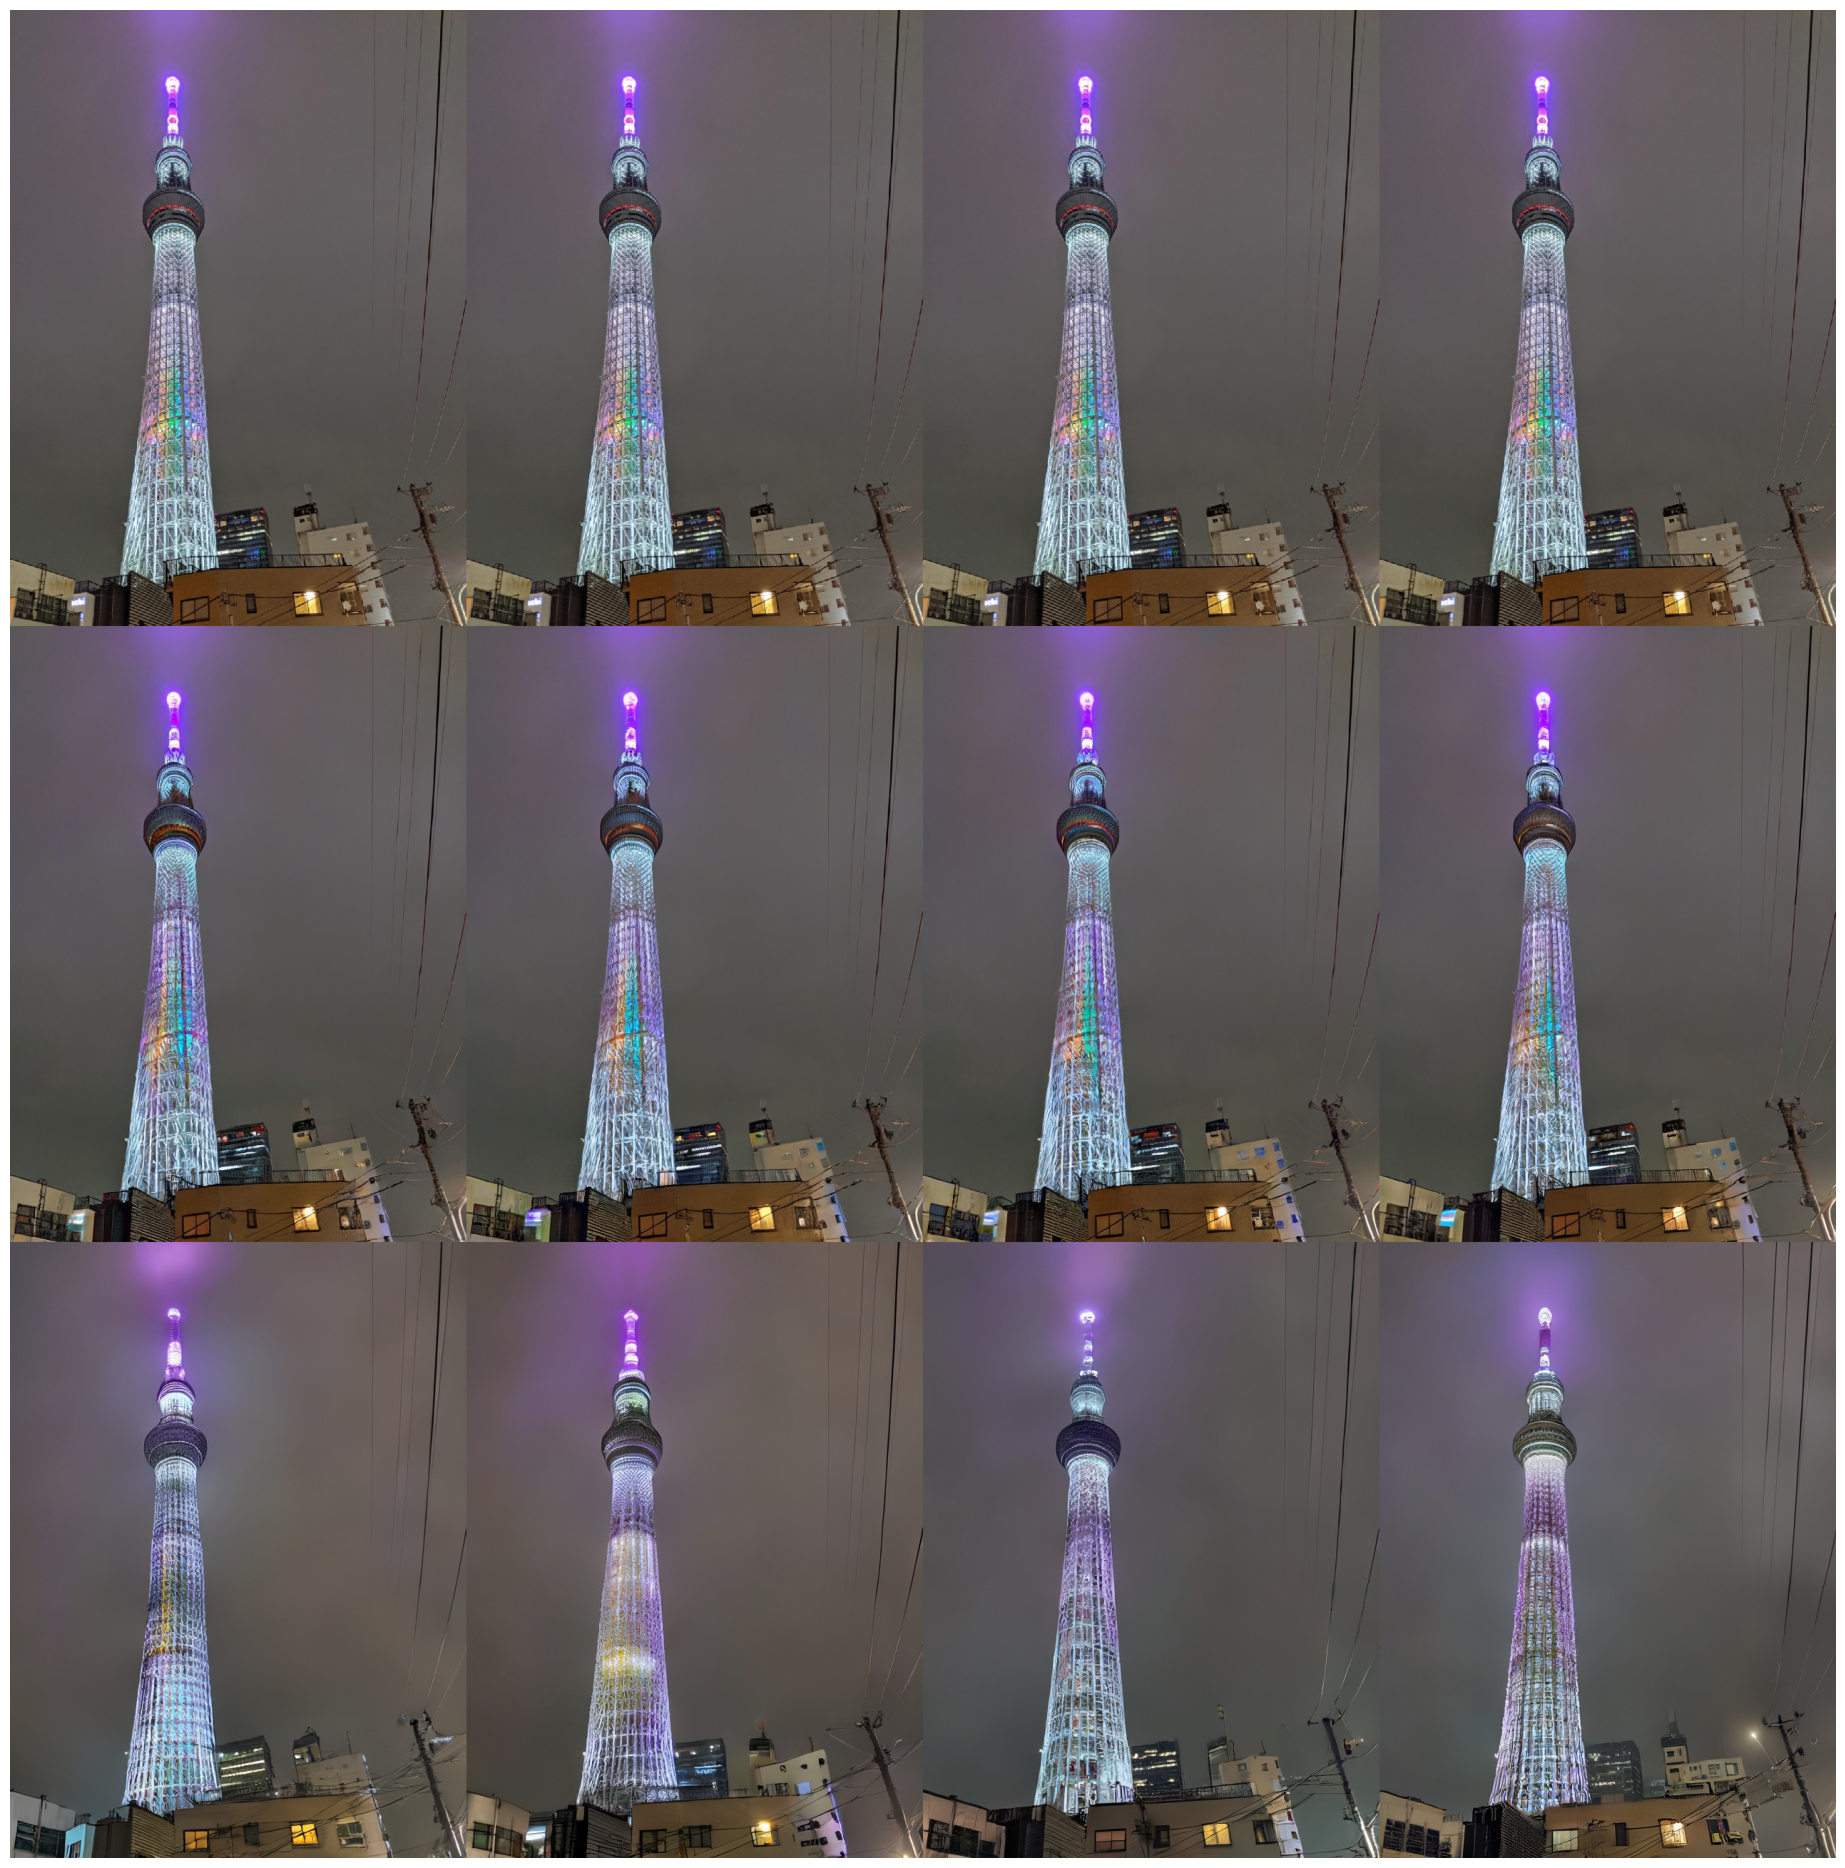

In [6]:
# STAGE B SAMPLING
conditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    conditions_b['effnet'] = effnet_latents
    unconditions_b['effnet'] = torch.zeros_like(effnet_latents)
    *_, (sampled_latents_b, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    
    conditions_b['effnet'] = sampled_latents
    unconditions_b['effnet'] = torch.zeros_like(sampled_latents)
    *_, (sampled_latents_b_corrupted, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    
    sampled_b = models_b.stage_a.decode(sampled_latents_b).float()
    sampled_b_corrupted = models_b.stage_a.decode(sampled_latents_b_corrupted).float()
    
    print(sampled_b.shape, sampled_b_corrupted.shape)
    
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in nn.functional.interpolate(batch['images'], size=sampled_b.shape[-2:]).cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b_corrupted.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [7]:
# print(effnet_latents[:1].shape)
# torch.save(effnet_latents[:1], f"effnet_latents.pt")

# GENERATE DATASET

In [8]:
dataset_path = "/weka/home-warp/samples/effnet_corrupted_v1/"
for i in tqdm(range(10000)):
    save_id = uuid.uuid1()
    batch = next(data.iterator)
    
    # RESIZE IMAGES
    orig_images = batch['images']
    effnet_factor = 3/4
    effnet_height, effnet_width = int(((batch['images'].size(-2)*effnet_factor)//32)*32), int(((batch['images'].size(-1)*effnet_factor)//32)*32)
    batch['images'] = torchvision.transforms.functional.resize(batch['images'], (effnet_height, effnet_width), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    
    batch['images'] = batch['images'].expand(4, -1, -1, -1)
    batch['captions'] = batch['captions'] * 4
    
    conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
    unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    

    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
        torch.manual_seed(42)

        effnet_latents = warpcore.encode_latents(batch, models, extras)
        
        latents = None
        for i in range(2):
            t_start = np.random.uniform(0.2, 0.5)
            t = torch.ones(effnet_latents.size(0), device=device) * t_start
            epsilon = torch.randn_like(effnet_latents)
            noised_latents = extras.gdf.diffuse(effnet_latents, epsilon=epsilon, t=t)[0]
            *_, (sampled_latents, _, _) = extras.gdf.sample(
                models.generator, conditions, effnet_latents.shape,
                unconditions, device=device, x_init=noised_latents, t_start=t_start,
                **{**extras.sampling_configs, 'timesteps': max(int(20*t_start), 1), "cfg": 4}
            )

            if latents is None:
                latents = sampled_latents
            else:
                latents = torch.cat([latents, sampled_latents], dim=0)
         
        torch.save(latents, f"{dataset_path}{save_id}.pt")
        torchvision.io.write_jpeg(orig_images[0].mul(255).to(torch.uint8), f"{dataset_path}{save_id}.jpg", quality=100)
        with open(f"{dataset_path}{save_id}.txt", 'w') as f:
            f.write(batch['captions'][0])
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:51:27<00:00,  4.63s/it]


In [9]:
# !rm /weka/home-warp/samples/effnet_corrupted_v1.tar
# !tar --sort=name -cf /weka/home-warp/samples/effnet_corrupted_v1.tar /weka/home-warp/samples/effnet_corrupted_v1/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
tar: Removing leading `/' from member names


# TEST CORRUPTED LOADE

In [10]:
from train_b_corrupted import WurstCore as WurstCoreB


In [11]:
# SETUP WARPCORE
config_file = 'configs/finetune_b_3b_corrupted.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 4

warpcore = WurstCoreB(
    config_dict=loaded_config,
    device=device
)


>>> RESUMING TRAINING FROM ITER  1


In [12]:
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)


Training with batch size 4 (4/GPU)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | 

download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_D3_F_CONT_PNG/00000329.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/PixelArt_STATIC/00007.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_BETAF/000099.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_D3_F_CONT_PNG/00000296.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/wallpaper_submissions/00000.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/IMG_MJ_500K_RISING/00028_2.tar to - [Errno 32] Broken pipe
download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/natureporn_submissions/00001_4.tar to - [Errno 32] Broken pipe


download failed: s3://applied-west-protected/cog_contextual_combined_1mp/tars/wallhaven/00021_3.tar to - [Errno 32] Broken pipe


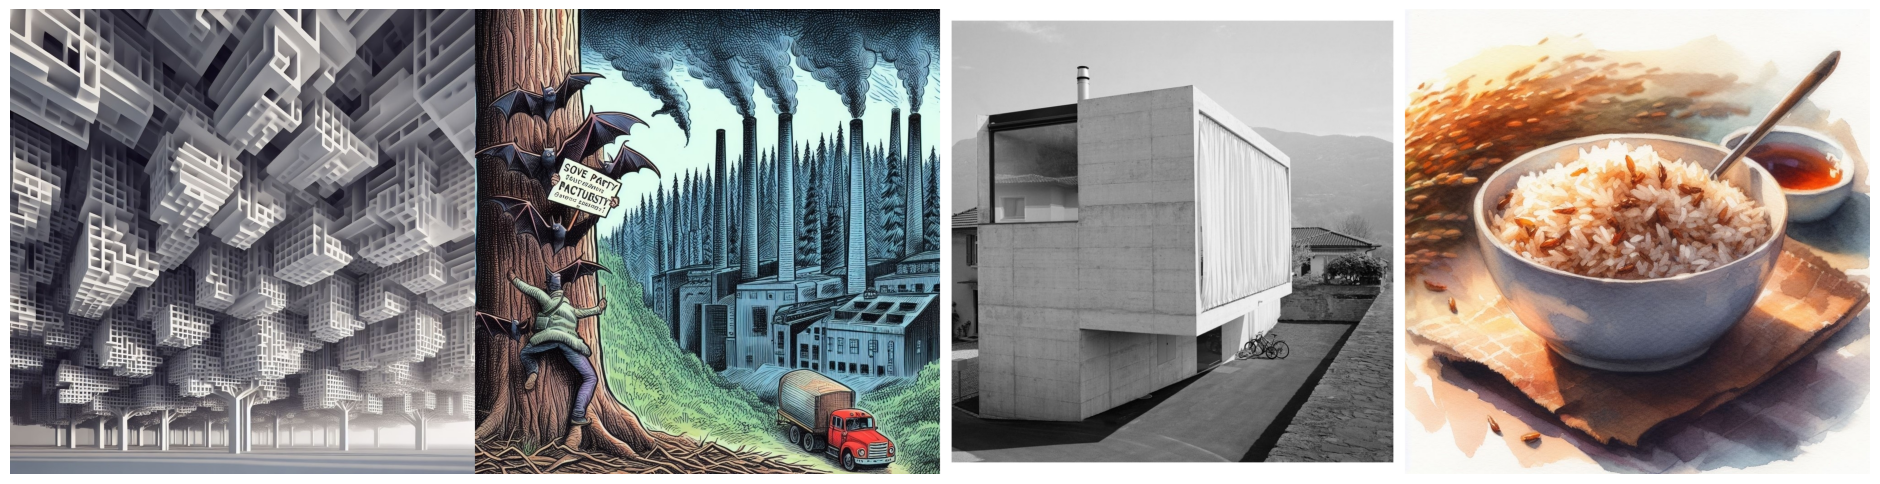

['A gray-white building structure comprises multiple geometric shapes, forming a tree-like shape. Below them are several straight pillars.', 'This cartoon depicts a scene of environmental protection. A man wearing a green jacket and blue pants is hanging on a tall tree, protecting three black bats from danger. There are many scattered bats around the man, all clinging tightly to the tree trunk with their bodies. The forest in the background consists of numerous tall red trees, which create an impressive landscape. In the distance, there is also a factory located near the edge of the woodland, emitting large amounts of gray smoke into the air, polluting the environment. Above the image, dark clouds cover the sky, adding a sense of gloom to this picture. On the right side of the image, there is a road with a yellow car passing by, possibly bringing goods or people to the industrial area.', 'A modern building made of concrete, with a large window and transparent curtains on the wall. Ther

In [13]:
# PREVIEW BATCH
batch = next(data.iterator)
batch['images'] = batch['images']
batch['captions'] = batch['captions']

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'])
print(batch['latents'].shape)